In [ ]:
#%cd /content/gdrive/MyDrive/Project_dataset
#!unzip -qq /content/gdrive/MyDrive/Project_dataset/seg_pred.zip
#!unzip -qq /content/gdrive/MyDrive/Project_dataset/seg_test.zip
#!unzip -qq /content/gdrive/MyDrive/Project_dataset/seg_train.zip

#### Preset

In [ ]:
import pandas as pd
import os
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
random.seed(42)

from google.colab import drive
drive.mount('/content/gdrive')


for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/Project_dataset/seg_train'):
    for filename in filenames:
        os.path.join(dirname, filename)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from PIL import Image
import numpy as np
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

TRAIN_DIR = '/content/gdrive/MyDrive/Project_dataset/seg_train'
TEST_DIR = '/content/gdrive/MyDrive/Project_dataset/seg_test'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_DIR,
  seed=42,
  image_size=(150, 150),
  batch_size=64,
  label_mode = 'categorical')
class_names = train_ds.class_names
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TEST_DIR,
  seed=42,
  image_size=(150, 150),
  batch_size=64,
  label_mode = 'categorical')

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(42).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print(class_names)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 32733 files belonging to 9 classes.
Found 3070 files belonging to 9 classes.
['architecture', 'buildings', 'food_and_drinks', 'forest', 'glacier', 'mountain', 'people', 'sea', 'street']


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [ ]:
image = train_ds.take(1)
image

<_TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

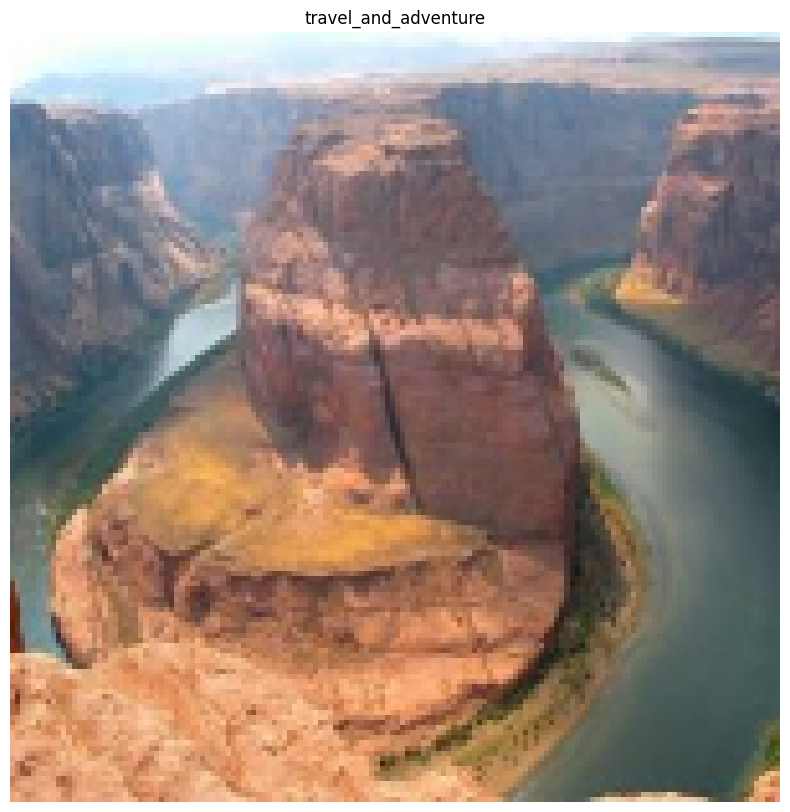

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(1):
    ax = plt.subplot(1, 1, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = tf.argmax(labels[i]).numpy()
    plt.title(class_names[label])
    plt.axis("off")

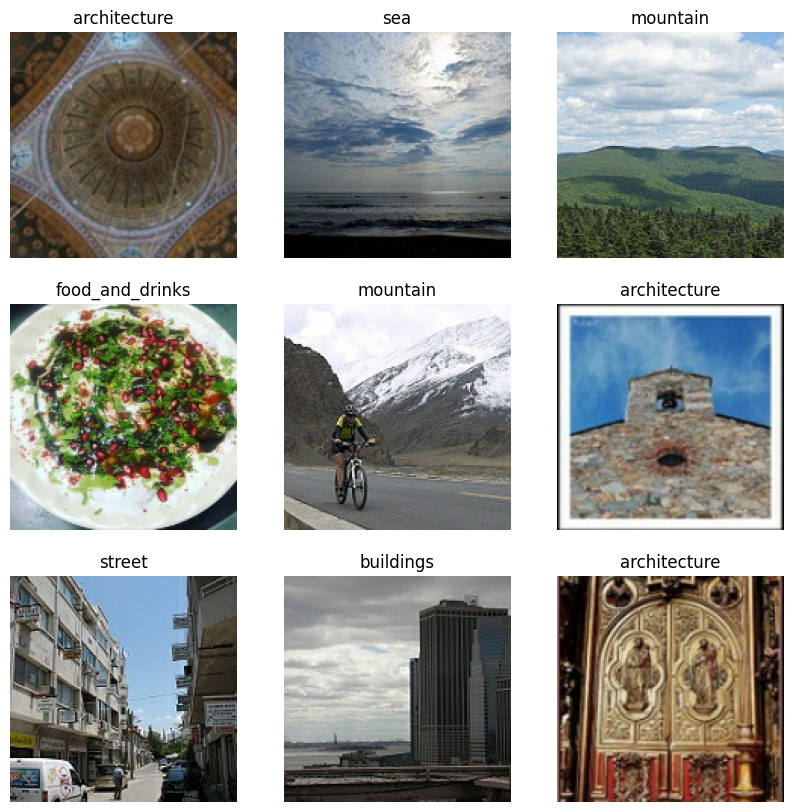

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = tf.argmax(labels[i]).numpy()
    plt.title(class_names[label])
    plt.axis("off")

#### CNN

In [ ]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(150, 150, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, steps_per_epoch=len(train_ds), epochs=10)

Epoch 1/10
503/766 [==================>...........] - ETA: 9:37 - loss: 1.0619 - accuracy: 0.6163

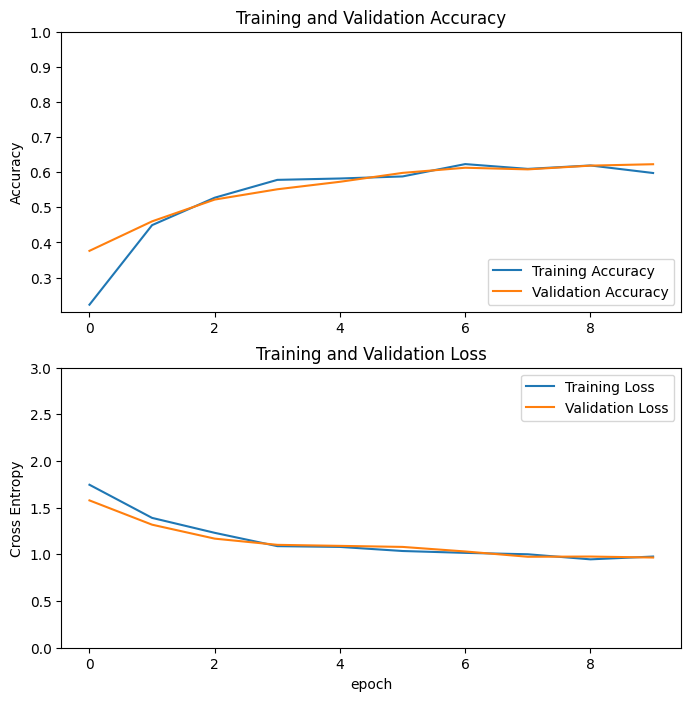

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Pretrained Model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (150, 150, 3)),
    base_model,
    layers.Conv2D(64, (3,3), activation='silu'),
    layers.Flatten(),
    layers.Dense(256, activation = 'silu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history3 = model.fit(train_ds, validation_data = val_ds, steps_per_epoch = 10, epochs = 10)

Epoch 1/10
10/10 [==============================] - 411s 26s/step - loss: 1.8727 - accuracy: 0.4625 - val_loss: 6.9607 - val_accuracy: 0.0430
Epoch 2/10
10/10 [==============================] - 111s 12s/step - loss: 0.8639 - accuracy: 0.7109 - val_loss: 4.0298 - val_accuracy: 0.3052
Epoch 3/10
10/10 [==============================] - 104s 11s/step - loss: 0.6342 - accuracy: 0.8141 - val_loss: 2.8737 - val_accuracy: 0.4752
Epoch 4/10
10/10 [==============================] - 97s 11s/step - loss: 0.7153 - accuracy: 0.7969 - val_loss: 2.0347 - val_accuracy: 0.5629
Epoch 5/10
10/10 [==============================] - 97s 11s/step - loss: 0.5703 - accuracy: 0.8297 - val_loss: 1.2667 - val_accuracy: 0.6896
Epoch 6/10
10/10 [==============================] - 97s 11s/step - loss: 0.5513 - accuracy: 0.8266 - val_loss: 1.0579 - val_accuracy: 0.7231
Epoch 7/10
10/10 [==============================] - 97s 11s/step - loss: 0.5128 - accuracy: 0.8297 - val_loss: 0.8504 - val_accuracy: 0.7720
Epoch 8/10

In [ ]:
print("Model accuracy: " + str(round(history3.history['val_accuracy'][9],4)) + "  and loss:  " +  str(round(history3.history['val_loss'][9],4)))

Model accuracy: 0.8296  and loss:  0.5732


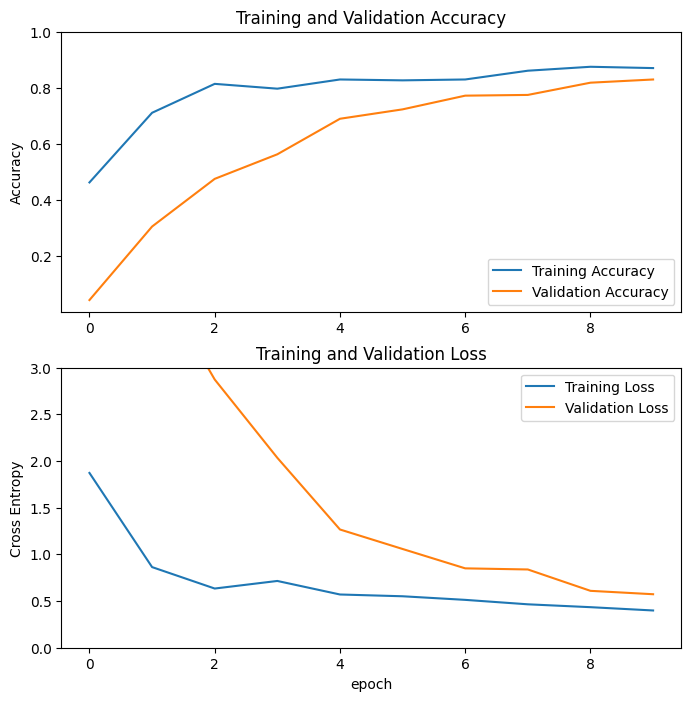

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

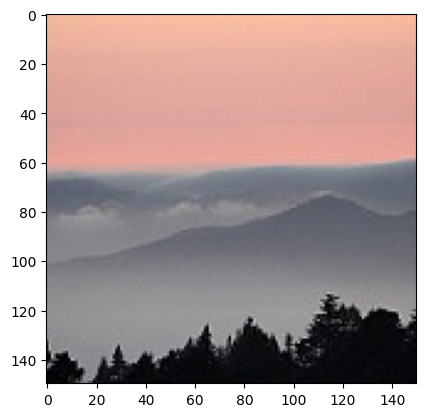

In [ ]:
img = tf.keras.utils.load_img('/content/gdrive/MyDrive/Project_dataset/seg_pred/10047.jpg')
plt.imshow(img) 

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 2s 2s/step
This image most likely belongs to mountain with a 15.596 percent confidence.


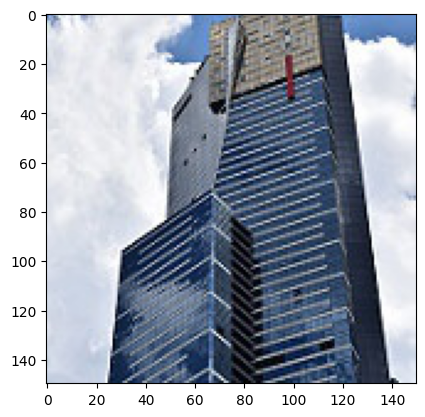

In [ ]:
img = tf.keras.utils.load_img('/content/gdrive/MyDrive/Project_dataset/seg_test/buildings/20057.jpg')
plt.imshow(img)

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 63ms/step
This image most likely belongs to buildings with a 25.017 percent confidence.


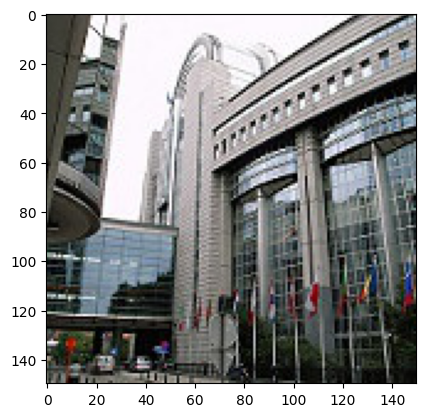

In [ ]:
img = tf.keras.utils.load_img('/content/gdrive/MyDrive/Project_dataset/seg_pred/10090.jpg')
plt.imshow(img) 

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 69ms/step
This image most likely belongs to street with a 16.126 percent confidence.


In [ ]:
print(score)

tf.Tensor(
[0.09804147 0.15699653 0.09720189 0.09737346 0.09727214 0.09721261
 0.09722639 0.09741656 0.16125898], shape=(9,), dtype=float32)


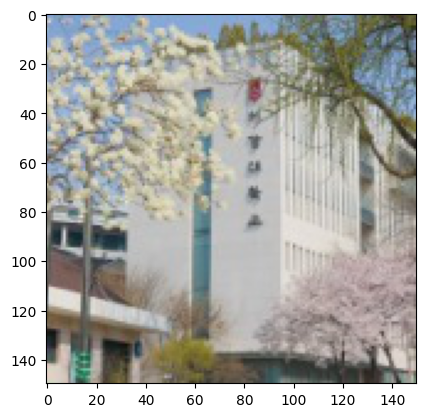

In [ ]:
img = tf.keras.utils.load_img('/content/gdrive/MyDrive/Project_dataset/seg_pred/testimage.jpeg')
plt.imshow(img) 

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 71ms/step
This image most likely belongs to buildings with a 16.856 percent confidence.


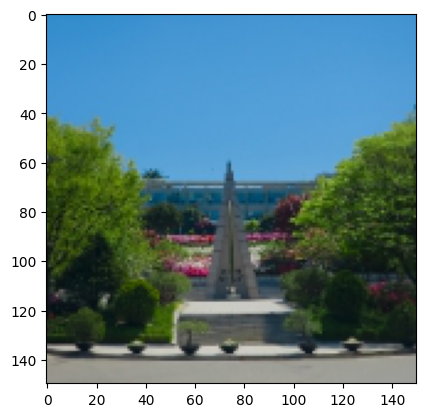

In [ ]:
img = tf.keras.utils.load_img('/content/gdrive/MyDrive/Project_dataset/seg_pred/testimage2.jpeg')
plt.imshow(img) 

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 87ms/step
This image most likely belongs to buildings with a 13.578 percent confidence.


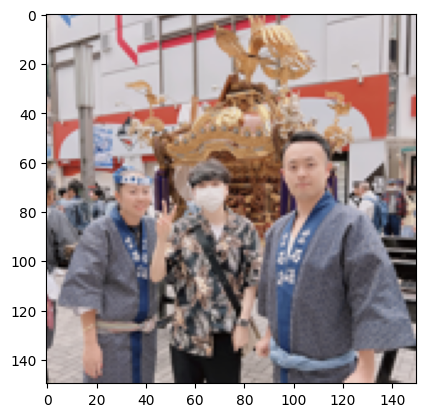

In [ ]:
def resizeImage(path, size : tuple) :
    from PIL import Image
    img = Image.open(path)
    image_resize = img.resize(size)
    return image_resize

from PIL import Image

img = Image.open('/content/gdrive/MyDrive/Project_dataset/seg_pred/IMG_4222.JPG')

img_resize = img.resize((150, 150))
img_resize.save('/content/gdrive/MyDrive/Project_dataset/seg_pred/IMG_4222_1.JPG')

plt.imshow(img_resize) 

In [ ]:
img_array = tf.keras.utils.img_to_array(img_resize)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 90ms/step
This image most likely belongs to people with a 24.100 percent confidence.


#### VGG16

In [ ]:
from tensorflow.keras.applications import InceptionV4

base_model = InceptionV4(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (150, 150, 3)),
    base_model,
    layers.Conv2D(64, (3,3), activation='silu'),
    layers.Flatten(),
    layers.Dense(256, activation = 'silu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(9, activation = 'softmax')
])

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

ImportError: ignored

In [ ]:
history3 = model.fit(train_ds, validation_data = val_ds, steps_per_epoch = 10, epochs = 10)

Epoch 1/10
10/10 [==============================] - 485s 52s/step - loss: 1.6613 - accuracy: 0.4953 - val_loss: 1.7453 - val_accuracy: 0.3248
Epoch 2/10
10/10 [==============================] - 474s 52s/step - loss: 0.9921 - accuracy: 0.7156 - val_loss: 1.7856 - val_accuracy: 0.3186
Epoch 3/10
10/10 [==============================] - 477s 52s/step - loss: 0.7890 - accuracy: 0.7531 - val_loss: 1.8840 - val_accuracy: 0.3072
Epoch 4/10
10/10 [==============================] - 487s 53s/step - loss: 0.6844 - accuracy: 0.7688 - val_loss: 1.5636 - val_accuracy: 0.4629
Epoch 5/10
10/10 [==============================] - 475s 52s/step - loss: 0.5601 - accuracy: 0.8266 - val_loss: 0.9880 - val_accuracy: 0.6847
Epoch 6/10
10/10 [==============================] - 523s 57s/step - loss: 0.5900 - accuracy: 0.8078 - val_loss: 0.9711 - val_accuracy: 0.6697
Epoch 7/10
10/10 [==============================] - 474s 52s/step - loss: 0.6005 - accuracy: 0.8000 - val_loss: 0.9272 - val_accuracy: 0.6785
Epoch 

KeyboardInterrupt: ignored